In [14]:
import skimage
import keras
import numpy as np
from keras import backend as K
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D, GlobalAveragePooling2D, Add
from keras import Model
from keras.layers import concatenate
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
# change size of every picture to 32x32
# add new col for chanel of gray gradation
x_train = np.array([skimage.transform.resize(image, (32, 32)) for image in np.expand_dims(x_train, -1)])[:10000]
x_test = np.array([skimage.transform.resize(image, (32, 32)) for image in np.expand_dims(x_test, -1)])
y_train = y_train.astype('int')[:10000]
y_test = y_test.astype('int')

train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

In [1]:
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

4422102/4422102 [==============================] - 0s 0us/step
train groups: [942, 1027, 1016, 1019, 974, 989, 1021, 1022, 990, 1000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [15]:
class ResidualBlock(Model):
    def __init__(self, channel_in = 64, channel_out = 256):
        super().__init__()

        channel = channel_out // 4

        # fast conect add to 3rd block than activate
        self.conv1 = Conv2D(channel, kernel_size = (1, 1), padding = "same")
        self.bn1 = BatchNormalization()
        self.av1 = Activation(tf.nn.relu)
        self.conv2 = Conv2D(channel, kernel_size = (3, 3), padding = "same")
        self.bn2 = BatchNormalization()
        self.av2 = Activation(tf.nn.relu)
        self.conv3 = Conv2D(channel_out, kernel_size = (1, 1), padding = "same")
        self.bn3 = BatchNormalization()
        self.shortcut = self._shortcut(channel_in, channel_out)
        self.add = Add()
        self.av3 = Activation(tf.nn.relu)

    # in tensor work in RB to create out tensor
    def call(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.av1(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.av2(h)
        h = self.conv3(h)
        h = self.bn3(h)
        shortcut = self.shortcut(x)
        h = self.add([h, shortcut])
        y = self.av3(h)
        return y

    # fast conection, which one is function of identify or proection
    def _shortcut(self, channel_in, channel_out):
        if channel_in == channel_out:
            return lambda x : x
        else:
            return self._projection(channel_out)

    # proection for different number of in/out chanel
    def _projection(self, channel_out):
        return Conv2D(channel_out, kernel_size = (1, 1), padding = "same")

In [20]:
class DenceNet(Model):
    def __init__(self, input_shape, output_dim):
        super().__init__()

        self._layers = [
            # conv1
            Conv2D(64, input_shape = input_shape, kernel_size = (7, 7), strides=(2, 2), padding = "same"),
            BatchNormalization(),
            Activation(tf.nn.relu),
            # conv2_x
            MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same"),
            ResidualBlock(64, 256),
            [
                ResidualBlock(256, 256) for _ in range(2)
            ],
            # conv3_x
            Conv2D(512, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(512, 512) for _ in range(4)
            ],
            # conv4_x
            Conv2D(1024, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(1024, 1024) for _ in range(6)
            ],
            # conv5_x
            Conv2D(2048, kernel_size = (1, 1), strides=(2, 2)),
            [
                ResidualBlock(2048, 2048) for _ in range(3)
            ],
            # last part
            GlobalAveragePooling2D(), # take mean of every cart object
            Dense(1000, activation = tf.nn.relu),
            Dense(output_dim, activation = tf.nn.softmax)
        ]
    # step-by-step calling blocks, if block are list
    def call(self, x):
        for layer in self._layers:
            if isinstance(layer, list):
                for l in layer:
                    x = l(x)
            else:
                x = layer(x)
        return x

In [21]:
model = DenceNet((28, 28, 1), 10)
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "dence_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         multiple                  3200      
                                                                 
 batch_normalization_100 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 activation_100 (Activation)  multiple                 0         
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 residual_block_32 (Residual  multiple                 75904     
 Block)                                                          
                                                         

In [3]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
        
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

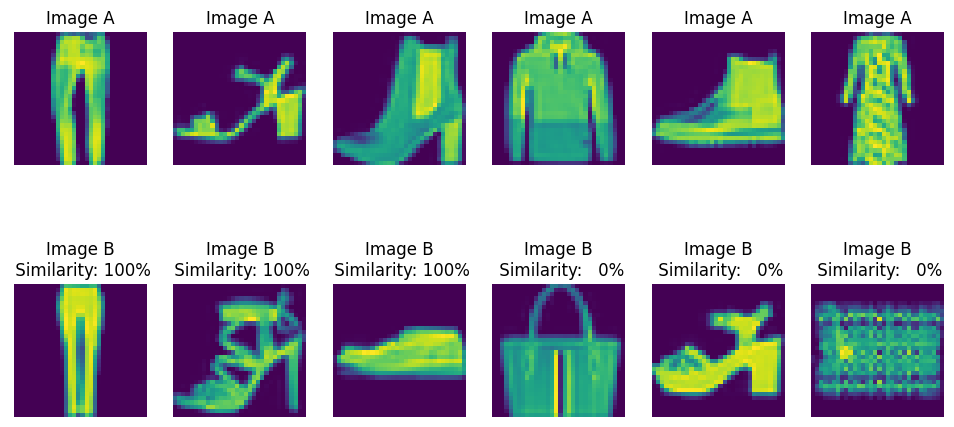

In [4]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
  ax1.imshow(c_a[:,:,0])
  ax1.set_title('Image A')
  ax1.axis('off')
  ax2.imshow(c_b[:,:,0])
  ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
  ax2.axis('off')

In [5]:
%%time
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs = 4, batch_size = 16, validation_split = 0.2, verbose = 1)

Epoch 1/4
500/500 [==============================] - 4027s 8s/step - loss: 1.1875 - accuracy: 0.6540 - val_loss: 0.8460 - val_accuracy: 0.6870
Epoch 2/4
500/500 [==============================] - 1634s 3s/step - loss: 0.6168 - accuracy: 0.7761 - val_loss: 0.6350 - val_accuracy: 0.7620
Epoch 3/4
500/500 [==============================] - 2753s 6s/step - loss: 0.5367 - accuracy: 0.8096 - val_loss: 0.5659 - val_accuracy: 0.8125
Epoch 4/4
500/500 [==============================] - 574s 1s/step - loss: 0.5026 - accuracy: 0.8265 - val_loss: 0.7000 - val_accuracy: 0.7570
CPU times: total: 51min 1s
Wall time: 2h 29min 49s


In [6]:
img_a_in = tf.keras.layers.Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = tf.keras.layers.Input(shape=x_train.shape[1:], name='ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name='features')
features = tf.keras.layers.Dense(16, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(4, activation='relu')(features)
features = tf.keras.layers.BatchNormalization()(features)
features = tf.keras.layers.Activation('relu')(features)
features = tf.keras.layers.Dense(1, activation='sigmoid')(features)

siamese_model = tf.keras.models.Model(inputs=[img_a_feat, img_b_feat], outputs=[features], name='Siamese_model')
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 features (Concatenate)         (None, 20)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 16)           336         ['features[1][0]']   

In [7]:
def show_model_output(nb_examples=3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:, :, 0])
        ax1.set_title(f'Image A\n Actual: {100 * c_d}')
        ax1.axis('off')
        ax2.imshow(c_b[:, :, 0])
        ax2.set_title(f'Image B\n Predicted: {int(100 * p_d[0])}')
        ax2.axis('off')
        
    return fig

1/1 [==============================] - 0s 117ms/step


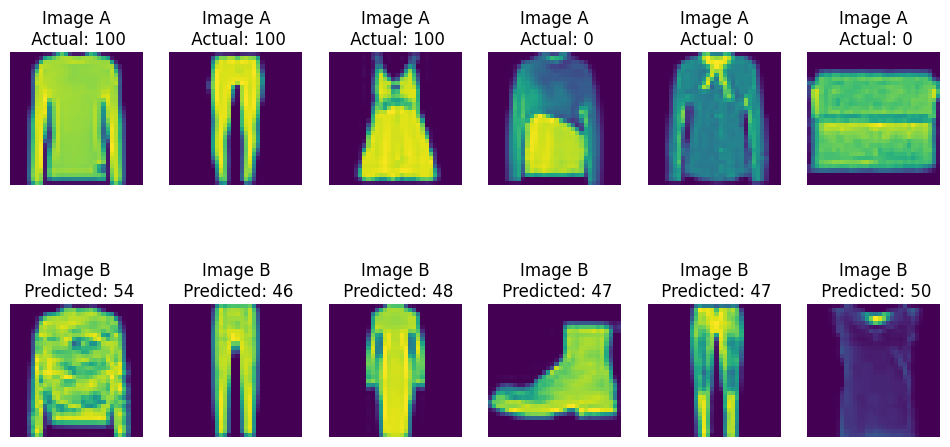

In [8]:
_ = show_model_output()

In [ ]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size // 2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

Цей блок коду навчає модель сіамської мережі за допомогою методу підгонки з функцією генератора siam_gen, яку ми визначили раніше.

Функція gen_random_batch викликається для створення набору перевірки пар зображень і балів схожості, які призначаються valid_a, valid_b і valid_sim відповідно.

Метод fit викликається в об’єкті siamese_model і йому передаються такі аргументи:

Функція генератора siam_gen передається як навчальні дані.
Для аргументу steps_per_epoch встановлено значення 500, яке вказує, скільки пакетів даних використовувати для кожної епохи. У цьому випадку кожен пакет складатиметься з пар зображень batch_size, тому steps_per_epoch дорівнює кількості пар у навчальних даних, поділеному на batch_size і округленому до найближчого цілого числа.

Дані перевірки вказуються за допомогою аргументу validation_data, який є кортежем, що складається з векторів ознак для пар зображень перевірки (отриманих шляхом виклику model.predict(valid_a) і model.predict(valid_b)) і відповідних показників подібності valid_sim.

Аргументу «epochs» встановлено значення 2, яке вказує, скільки разів повторювати весь навчальний набір даних.

Для аргументу «verbose» встановлено значення True, що відображає панель прогресу навчання на консолі.

Під час навчання сіамська мережа оптимізується за допомогою оптимізатора «adam» і мінімізується за допомогою функції втрат бінарної крос-ентропії. Показник "mae" також обчислюється та відображається під час навчання. Показники втрати та точності як для навчального, так і для перевірочного наборів записуються та повертаються в об’єкті «loss_history».

In [9]:
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(
                                siam_gen(train_groups),
                                steps_per_epoch=500,
                                validation_data=([model.predict(valid_a), model.predict(valid_b)], valid_sim),
                                epochs=2,
                                verbose=True)

1/1 [==============================] - 0s 111ms/step
Epoch 1/2
500/500 [==============================] - 180s 358ms/step - loss: 0.5546 - mae: 0.3979 - val_loss: 0.4384 - val_mae: 0.3168
Epoch 2/2
1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 28ms/step


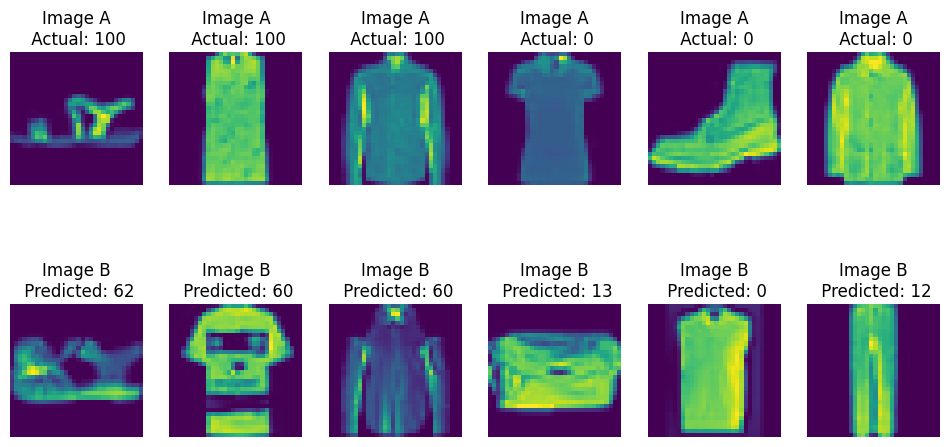

In [10]:
_ = show_model_output()

In [11]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 25s 319ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.023s...
[t-SNE] Computed neighbors for 10000 samples in 0.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.473095
[t-SNE] KL divergence a

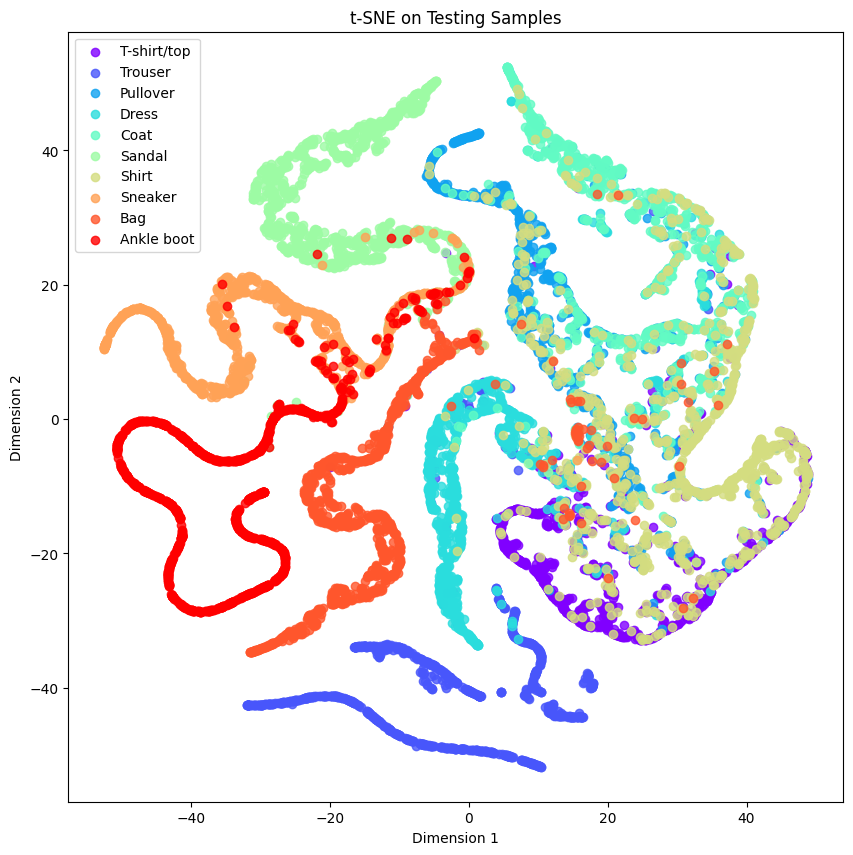

In [12]:
obj_categories = [
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

In [13]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
